In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/amsurve/PROJECTS/gg2/data/bbc_cleaned.csv')

In [3]:
df.shape

(2225, 7)

In [5]:
df.sample(5)    

,Unnamed: 0,Unnamed: 0.1,category,title,text,label,cleaned_text
296,296,296,entertainment,Surprise win for anti-Bush film,Surprise win for anti-Bush film\n\nMichael Moo...,3,surprise win antibush film michael moor docume...
108,108,108,entertainment,Volcano drama erupts on BBC One,Volcano drama erupts on BBC One\n\nSupervolcan...,3,volcano drama erupt bbc one supervolcano docud...
21,21,21,entertainment,Rapper 50 Cent ends protege feud,Rapper 50 Cent ends protege feud\n\nRapper 50 ...,3,rapper cent end protege feud public game pair ...
398,398,398,business,Euronext 'poised to make LSE bid',Euronext 'poised to make LSE bid'\n\nPan-Europ...,1,euronext poise make lse bid paneuropean group ...
1201,1201,1201,sport,Lions blow to World Cup stars,Lions blow to World Cup stars\n\nBritish and I...,2,lion blow world cup star british irish coach c...


In [64]:
label_df = df[['category', 'label']].drop_duplicates().sort_values('label').reset_index().drop('index',1)
label_df

,category,label
0,tech,0
1,business,1
2,sport,2
3,entertainment,3
4,politics,4


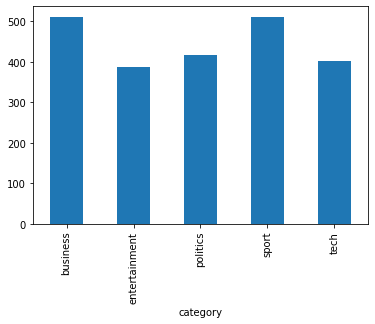

In [5]:
df.groupby('category').label.count().plot.bar(ylim=0)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.cleaned_text).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = df.label                           # represents the category of each of the 1490 articles
print(features.shape )

(2225, 9288)


In [8]:
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

### Wordcloud for entire data

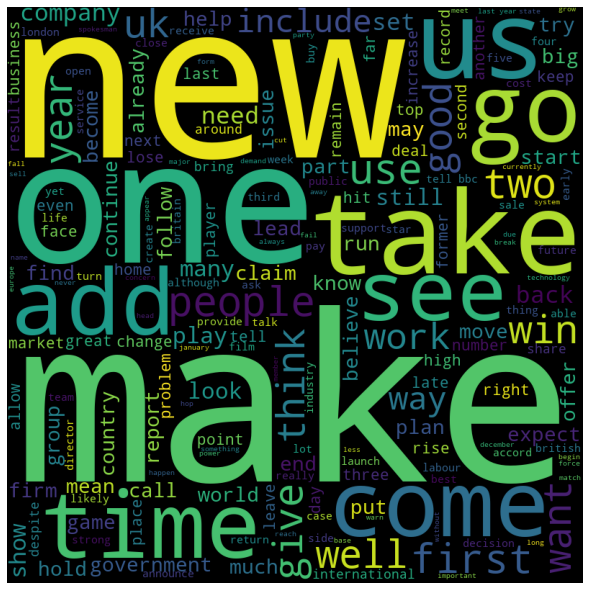

In [9]:
texts = ''
for index, item in df.iterrows():
    texts = texts + ' ' + item['cleaned_text']
    
plot_word_cloud(texts)

### Wordcloud for each category

In [10]:
def plot_word_cloud_for_category(df, category):
    text_df = df.loc[df['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + item['cleaned_text']
    
    plot_word_cloud(texts)


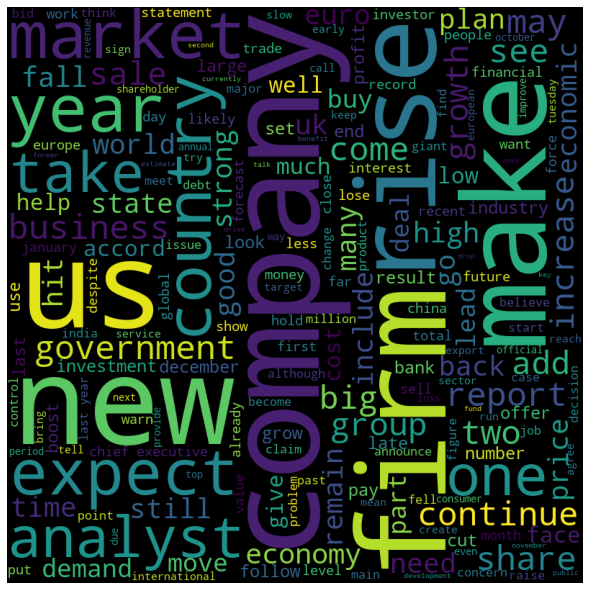

In [11]:
plot_word_cloud_for_category(df,'business')

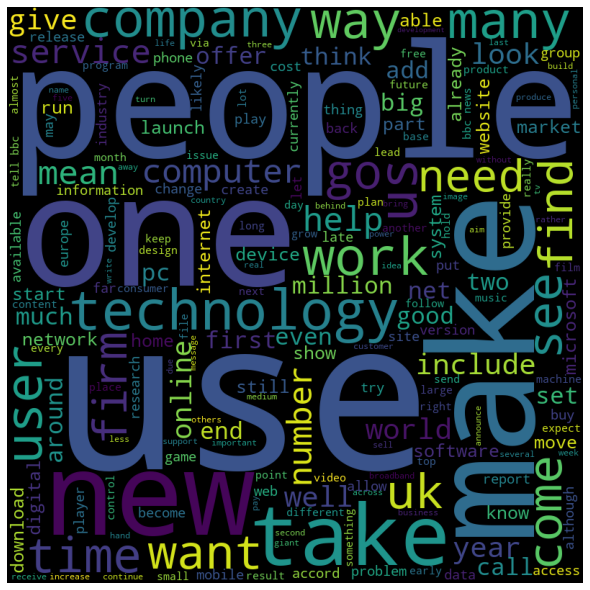

In [13]:
plot_word_cloud_for_category(df,'tech')

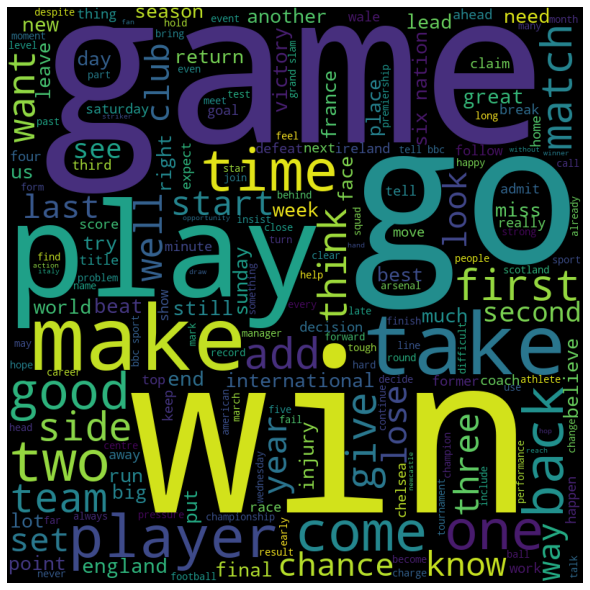

In [14]:
plot_word_cloud_for_category(df,'sport')

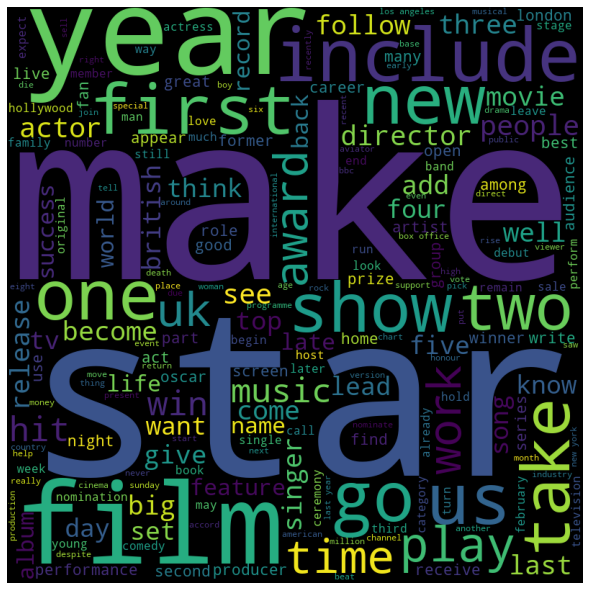

In [15]:
plot_word_cloud_for_category(df,'entertainment')

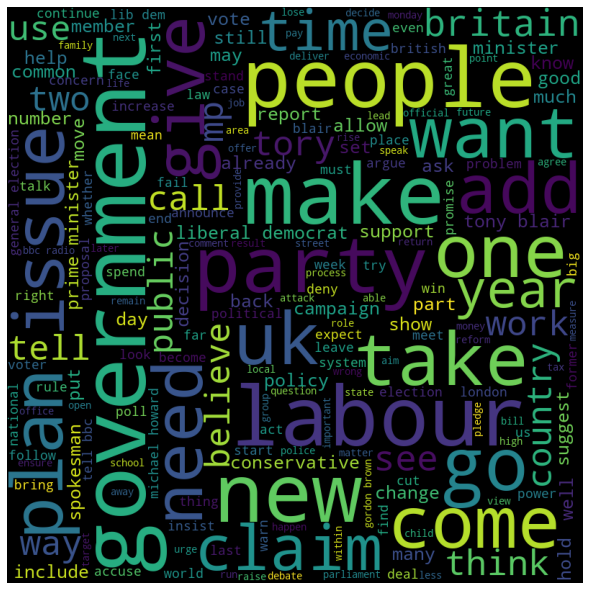

In [16]:
plot_word_cloud_for_category(df,'politics')

In [18]:
from sklearn.feature_selection import chi2
category2label = {'tech':0,'business':1,'sport':2,'entertainment':3,'politics':4}
N = 3  # We are going to look for top 3 categories

for category, label in sorted(category2label.items()):
    features_chi2 = chi2(features, labels == label)                   # Do chi2 analyses of all items in this category
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print('*'*50)
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat
print('*'*50)

**************************************************
# 'business':
  . Most correlated unigrams:
       . analyst
       . bank
       . growth
  . Most correlated bigrams:
       . chief executive
       . oil price
       . stock market
**************************************************
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . film
       . actor
  . Most correlated bigrams:
       . dollar baby
       . los angeles
       . box office
**************************************************
# 'politics':
  . Most correlated unigrams:
       . election
       . labour
       . tory
  . Most correlated bigrams:
       . michael howard
       . tony blair
       . liberal democrat
**************************************************
# 'sport':
  . Most correlated unigrams:
       . cup
       . champion
       . coach
  . Most correlated bigrams:
       . champion league
       . bbc sport
       . grand slam
**************************************************
# '